In [1]:
#import
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import cv2
from IPython.display import clear_output
import pickle

In [2]:
#instantiate drawing & hands
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [3]:
with open("dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [20]:
print(len(dataset))

50


1. one = 0
2. two = 1
3. three = 2
4. thumb = 3
5. fist = 4

In [18]:
dataset = []
cnt_data = np.zeros(5)

cap = cv2.VideoCapture(0)
hands = mp_hands.Hands(static_image_mode=False , max_num_hands = 1 , min_detection_confidence=0.7, min_tracking_confidence=0.5)

while cap.isOpened():
    success, img = cap.read()
    if not success:
        print("image fetch fail")
        continue
        
    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False
    results = hands.process(img)
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if results.multi_hand_landmarks is not None:
        hand_landmarks = results.multi_hand_landmarks[0]
        mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    strs = ""
    for cnt in cnt_data:
        strs += f"{int(cnt):02d} " 
    cv2.putText(img, strs , (50,50) , cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255))
    
    cv2.imshow("img",img)
    key_value = cv2.waitKey(5)
    
    if key_value == 27:
        break
        
    if key_value==49:
        data_pair = [hand_landmarks, 0]
        dataset.append(data_pair)
        cnt_data[0]+=1
    elif key_value==50:
        data_pair = [hand_landmarks, 1]
        dataset.append(data_pair)
        cnt_data[1]+=1
    elif key_value==51:
        data_pair = [hand_landmarks, 2]
        dataset.append(data_pair)
        cnt_data[2]+=1
    elif key_value==52:
        data_pair = [hand_landmarks, 3]
        dataset.append(data_pair)
        cnt_data[3]+=1
    elif key_value==53:
        data_pair = [hand_landmarks, 4]
        dataset.append(data_pair)
        cnt_data[4]+=1
    elif key_value==27:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

In [21]:
#determine
def simple_classification(hand_landmarks):
    finger_up = [False, False, False, False, False]
    
    if(hand_landmarks.landmark[4].y < hand_landmarks.landmark[3].y
       and hand_landmarks.landmark[3].y < hand_landmarks.landmark[2].y
       and hand_landmarks.landmark[2].y < hand_landmarks.landmark[1].y
       and hand_landmarks.landmark[1].y < hand_landmarks.landmark[0].y
       and hand_landmarks.landmark[3].y < hand_landmarks.landmark[6].y 
      ):
        finger_up[0] = True
    if(hand_landmarks.landmark[8].y < hand_landmarks.landmark[7].y
       and hand_landmarks.landmark[7].y < hand_landmarks.landmark[6].y
       and hand_landmarks.landmark[6].y < hand_landmarks.landmark[5].y
       and hand_landmarks.landmark[5].y < hand_landmarks.landmark[0].y
      ):
        finger_up[1] = True
    if(hand_landmarks.landmark[12].y < hand_landmarks.landmark[11].y
       and hand_landmarks.landmark[11].y < hand_landmarks.landmark[10].y
       and hand_landmarks.landmark[10].y < hand_landmarks.landmark[9].y
       and hand_landmarks.landmark[9].y < hand_landmarks.landmark[0].y\
      ):
        finger_up[2] = True
    if(hand_landmarks.landmark[16].y < hand_landmarks.landmark[15].y
       and hand_landmarks.landmark[15].y < hand_landmarks.landmark[14].y
       and hand_landmarks.landmark[14].y < hand_landmarks.landmark[13].y
       and hand_landmarks.landmark[13].y < hand_landmarks.landmark[0].y
      ):
        finger_up[3] = True
    if(hand_landmarks.landmark[20].y < hand_landmarks.landmark[19].y 
       and hand_landmarks.landmark[19].y < hand_landmarks.landmark[18].y 
       and hand_landmarks.landmark[18].y < hand_landmarks.landmark[17].y
       and hand_landmarks.landmark[17].y < hand_landmarks.landmark[0].y
      ):
        finger_up[4] = True
    
    #print(finger_up)
    
    if(finger_up[1] and not finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 0
    elif(finger_up[1] and finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 1
    elif(finger_up[1] and finger_up[2] and finger_up[3] and not finger_up[4]):
        return 2
    elif(finger_up[0] and not finger_up[1] and not finger_up[2] and not finger_up[3] and not finger_up[4]):
        return 3
    else:
        return 4

In [23]:
hand_landmarks, true_class = dataset[0]

In [24]:
predict_class = simple_classification(hand_landmarks)
print(predict_class, true_class)

0 0


In [26]:
correct_cnt = 0
total_cnt = 0
for data in dataset:
    hand_landmarks, true_class = data
    predict_class = simple_classification(hand_landmarks)
    if (predict_class == true_class):
        correct_cnt +=1
    total_cnt+=1
print(f"accuracy : {correct_cnt * 100/total_cnt} %")

accuracy : 96.0 %


[[10.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0.  9.  0.  1.]
 [ 0.  0.  0.  9.  1.]
 [ 0.  0.  0.  0. 10.]]


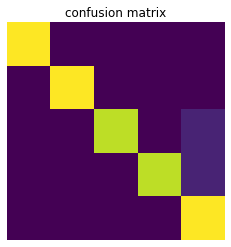

In [31]:
# confusion matrix
confusion_matrix = np.zeros((5,5))
for data in dataset:
    hand_landmarks, true_class = data
    predict_class = simple_classification(hand_landmarks)
    confusion_matrix[true_class, predict_class] +=1
print(confusion_matrix)

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)
ax.set_title("confusion matrix")
plt.axis("off")
plt.show()

In [4]:
# complex method
new_dataset = []
for data in dataset:
    hand_landmarks, true_class = data

    adjacency_list = [
        [0,1,2],[1,2,3],[2,3,4],[0,5,6],[5,6,7],[6,7,8],
        [0,9,10],[9,10,11],[10,11,12],[0,13,14],[13,14,15],
        [14,15,16],[0,17,18],[17,18,19],[18,19,20]
    ]

    angle_list=[]

    for adjacency in adjacency_list :
        idx0, idx1, idx2 = adjacency
        point0 = np.array([hand_landmarks.landmark[idx0].x, hand_landmarks.landmark[idx0].y, hand_landmarks.landmark[idx0].z])
        point1 = np.array([hand_landmarks.landmark[idx1].x, hand_landmarks.landmark[idx1].y, hand_landmarks.landmark[idx1].z])
        point2 = np.array([hand_landmarks.landmark[idx2].x, hand_landmarks.landmark[idx2].y, hand_landmarks.landmark[idx2].z])

        vector0 = point0 - point1
        vector1 = point2 - point1
        inner_product_result = np.dot(vector0,vector1)
        cos_theta = inner_product_result/(np.linalg.norm(vector0) * np.linalg.norm(vector1))
        theta = np.arccos(cos_theta)
        angle_list.append(theta)
    
    new_dataset.append([angle_list, true_class])


In [39]:
with open("new_dataset.pkl", "wb")as f:
    pickle.dump(new_dataset,f)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
classifier = KNeighborsClassifier(n_neighbors=3)

In [13]:
training_inputs = []
training_labels = []
for data in new_dataset:
    angle_list, true_class = data
    training_inputs.append(angle_list)
    training_labels.append(true_class)
classifier.fit(training_inputs, training_labels)

KNeighborsClassifier(n_neighbors=3)

In [14]:
print(classifier)

KNeighborsClassifier(n_neighbors=3)


In [15]:
classifier.predict(training_inputs)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [16]:
correct_cnt = 0
total_cnt = 0
for data in new_dataset:
    angle_list, true_class = data
    predict_class = classifier.predict([angle_list])[0]
    if (predict_class == true_class):
        correct_cnt +=1
    total_cnt+=1
print(f"accuracy : {correct_cnt * 100/total_cnt} %")

accuracy : 98.0 %


[[10.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.]
 [ 0.  0.  1.  9.  0.]
 [ 0.  0.  0.  0. 10.]]


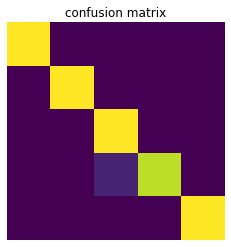

In [17]:
# confusion matrix
confusion_matrix = np.zeros((5,5))
for data in new_dataset:
    angle_list, true_class = data
    predict_class = classifier.predict([angle_list])[0]
    confusion_matrix[true_class, predict_class] +=1
print(confusion_matrix)

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)
ax.set_title("confusion matrix")
plt.axis("off")
plt.show()

In [18]:
# seperate training data & test data

In [21]:
class HandGesture:
    def __init__(self):
        self.classifier = KNeighborsClassifier(n_neighbors=3)
        
        with open("new_dataset.pkl","rb") as f:
            dataset = pickle.load(f)
        training_inputs = []
        training_labels = []
        for data in new_dataset:
            angle_list, true_class = data
            training_inputs.append(angle_list)
            training_labels.append(true_class)
        self.classifier.fit(training_inputs, training_labels)
    
    def get_prediction(self, hand_landmarks):
        adjacency_list = [
            [0,1,2],[1,2,3],[2,3,4],[0,5,6],[5,6,7],[6,7,8],
            [0,9,10],[9,10,11],[10,11,12],[0,13,14],[13,14,15],
            [14,15,16],[0,17,18],[17,18,19],[18,19,20]
        ]

        angle_list=[]

        for adjacency in adjacency_list :
            idx0, idx1, idx2 = adjacency
            point0 = np.array([hand_landmarks.landmark[idx0].x, hand_landmarks.landmark[idx0].y, hand_landmarks.landmark[idx0].z])
            point1 = np.array([hand_landmarks.landmark[idx1].x, hand_landmarks.landmark[idx1].y, hand_landmarks.landmark[idx1].z])
            point2 = np.array([hand_landmarks.landmark[idx2].x, hand_landmarks.landmark[idx2].y, hand_landmarks.landmark[idx2].z])

            vector0 = point0 - point1
            vector1 = point2 - point1
            inner_product_result = np.dot(vector0,vector1)
            cos_theta = inner_product_result/(np.linalg.norm(vector0) * np.linalg.norm(vector1))
            theta = np.arccos(cos_theta)
            angle_list.append(theta)
            
        return self.classifier.predict([angle_list])[0]

In [22]:
hand_gesture = HandGesture()

In [23]:
hand_landmarks, true_class = dataset[0]
predict_class = hand_gesture.get_prediction(hand_landmarks)
print(predict_class, true_class)

0 0
